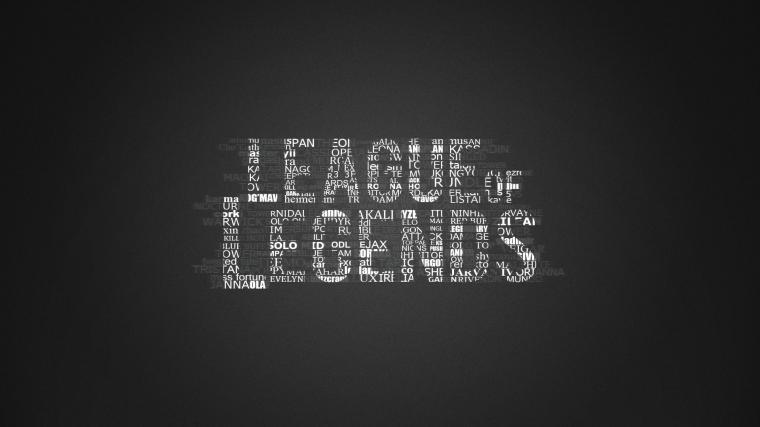

**Munish Kumar (June 2020)**

League of Legends (LoL) is a multiplayer online battle arena video game developed and published by Riot Games for Microsoft Windows and macOS. 

In LoL, players assume the role of a "champion" with unique abilities and battle against a team of other player- or computer-controlled champions. The goal is (usually) to destroy the opposing team's "Nexus", a structure that lies at the heart of a base, surrounded by defensive turret like structures. Each League of Legends match is discrete, with all champions starting off relatively weak but increasing in strength by accumulating items and experience over the course of the game.
*Caveat: I say usually because there are some distinct game modes that exist, with varying objectives, rules, and maps.*

This dataset contains the first 10 minute statistics of $\approx$10,000 ranked games (SOLO QUEUE) from a high ELO (DIAMOND I to MASTER). Players have roughly the same level. There are 19 features per team (38 in total); this includes kills, deaths, gold, experience, level etc. 

There are 2 objectives in this work:
1. Predict the blueWins (target value), where '1' represents a blue team victory. 
2. Understand which features are most crucial in leading to a victory.

### Import Libraries

In [1]:
# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
sns.set()

# Sklearn Liraries
from sklearn import preprocessing

from datetime import timedelta, date 
start = time.time()
%matplotlib inline

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


Declare some global variables

In [2]:
dir_name = 'C:/Users/quant/Anaconda3/@Projects/LoL_Diamond_Ranked_Games'
filename_suffix = 'csv'

Read in the data file

In [3]:
df=pd.read_csv('high_diamond_ranked_10min.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [4]:
df['red_gameId']=df['gameId']
columns_rename = {'gameId':'blue_gameId'}
df.rename(columns=columns_rename, inplace=True)
df

,blue_gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,red_gameId
0,4519157822,0,28,2,1,9,6,11,0,0,...,16567,6.8,17047,197,55,-643,8,19.7,1656.7,4519157822
1,4523371949,0,12,1,0,5,5,5,0,0,...,17620,6.8,17438,240,52,2908,1173,24.0,1762.0,4523371949
2,4521474530,0,15,0,0,7,11,4,1,1,...,17285,6.8,17254,203,28,1172,1033,20.3,1728.5,4521474530
3,4524384067,0,43,1,0,4,5,5,1,0,...,16478,7.0,17961,235,47,1321,7,23.5,1647.8,4524384067
4,4436033771,0,75,4,0,6,6,6,0,0,...,17404,7.0,18313,225,67,1004,-230,22.5,1740.4,4436033771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,4527873286,1,17,2,1,7,4,5,1,1,...,15246,6.8,16498,229,34,-2519,-2469,22.9,1524.6,4527873286
9875,4527797466,1,54,0,0,6,4,8,1,1,...,15456,7.0,18367,206,56,-782,-888,20.6,1545.6,4527797466
9876,4527713716,0,23,1,0,6,7,5,0,0,...,18319,7.4,19909,261,60,2416,1877,26.1,1831.9,4527713716
9877,4527628313,0,14,4,1,2,3,3,1,1,...,15298,7.2,18314,247,40,839,1085,24.7,1529.8,4527628313


As this is a single data file, it will be difficult to use it to test predictive modelling. Therefore, I will firstly split this file into a training-testing set, and a validation set. All the processing I need done will then be on the training-testing set.

#### Create an out-of-sample set

In [5]:
# Creates a mask where values that are true go into the training/test set
# Note that I done it so that the random number is predictable
msk = np.random.seed(0)
msk = np.random.rand(len(df))<0.8

raw_train_test_set = df[msk]
raw_validate_set = df[~msk]

print(raw_train_test_set.shape)
print(raw_validate_set.shape)

(7937, 41)
(1942, 41)


Here are the data fields:

| Field          | Description                                            |
|----------------|--------------------------------------------------------|
| blueWins       | Blue Team wins or not                                  |
| WardsPlaced    | Number of warding totems placed by the team on the map |
| WardsDestroyed | Number of enemy warding totems the team has destroyed  |
| FirstBlood     | First kill of game. 1 if the team did it, 0 otherwise  |
| Kills          | Number of deaths                                       |
| Deaths         | Number of enemies killed by the team                   |
| Assists        | Number of kill assists                                 |
| EliteMonsters  | Number of elite monsters killed by team (Dragons & Heralds)                                                                  |
| Dragons        | Number of dragons killed by the team                   |
| Heralds        | Number of heralds killed by the team                   |
| TowersDestroyed| Number of structures destroyed by the team (towers...) |
| TotalGold      | Team total gold                                        |
| AvgLevel       | Team average champion level                            |
| TotalExperience| Team total experience                                  |
| TotalMinionsKilled| Team total minions killed (CS)                      |
| TotalJungleMinionsKilled| Team total jungle monsters killed             |
| GoldDiff       | Team gold difference compared to the enemy team        |
| ExperienceDiff | Team experience difference compared to the enemy team  |
| CSPerMin       | Team CS (minions) per minute                           |
| GoldPerMin     | Team gold per minute                                   |
 
Glossary
 - Warding totem: An item that a player can put on the map to reveal the nearby area; used for map/objectives control.
 - Minions: NPC present in both teams; give gold when killed by players.
 - Jungle minions: NPC that belong to NO TEAM; give gold and buffs when killed by players.
 - Elite monsters: Monsters with high hp/damage that give a massive bonus (gold/XP/stats) when killed by a team.
 - Dragons: Elite monster which gives team bonus when killed. The 4th dragon killed by a team gives a massive stats bonus. The 5th dragon (Elder Dragon) offers a huge advantage to the team.
 - Herald: Elite monster which gives stats bonus when killed by the player. It helps to push a lane and destroys structures.
 - Towers: Structures that need to be destroyed to reach the enemy Nexus; gives gold upon wrecking.
 - Level: Champion level; start at 1 with a max at 18

The victory condition should logically be dependent on the difference between attributes, but its unclear which attribute is most important. For instance, is the warding more important or gold difference? 

Plotting the difference of each complementary pair would give some insight. 
Since we are interested in only the "Blue Wins", we need to filter out all data points not related to that.

# 1. Data Pre-Processing & Clean-up

In [6]:
bluewin_train_test_set = raw_train_test_set[
    raw_train_test_set['blueWins']==1]
print("Total Data set Size:", raw_train_test_set.shape[0])
print('Number of Blue Wins:', bluewin_train_test_set.shape[0])
print('Number of Red Wins:', (raw_train_test_set.shape[0]-bluewin_train_test_set.shape[0]))
bluewin_train_test_set

Total Data set Size: 7937
Number of Blue Wins: 3965
Number of Red Wins: 3972


,blue_gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,red_gameId
5,4475365709,1,18,0,0,5,3,6,1,1,...,15201,7.0,18060,221,59,-698,-101,22.1,1520.1,4475365709
6,4493010632,1,18,3,1,7,6,7,1,1,...,14463,6.4,15404,164,35,-2411,-1563,16.4,1446.3,4493010632
9,4509433346,1,13,1,1,4,5,5,1,1,...,16605,6.8,18379,247,43,1548,1574,24.7,1660.5,4509433346
12,4515594785,1,18,1,1,7,1,11,1,1,...,14591,6.8,17443,240,50,-3274,-1659,24.0,1459.1,4515594785
14,4516505202,1,15,3,1,4,4,4,0,0,...,16192,7.0,18083,242,48,470,187,24.2,1619.2,4516505202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9866,4527780032,1,16,3,0,1,2,0,1,1,...,13933,6.8,17032,197,52,-670,-1446,19.7,1393.3,4527780032
9868,4527960459,1,16,4,1,7,1,5,1,0,...,13936,6.8,16784,203,68,-3234,-2427,20.3,1393.6,4527960459
9872,4527650398,1,12,0,1,7,7,9,0,0,...,16399,7.0,18001,216,58,-756,-1,21.6,1639.9,4527650398
9874,4527873286,1,17,2,1,7,4,5,1,1,...,15246,6.8,16498,229,34,-2519,-2469,22.9,1524.6,4527873286


Split the data set into blue and red - first is the red data set

In [7]:
# Columns with a red in its name
#col_red = [col for col in df_mod.columns if 'red' in col]
#print(list(col_red))

df_red = bluewin_train_test_set.filter(regex='red')
df_red

,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,red_gameId
5,36,5,1,3,5,2,0,0,0,0,15201,7.0,18060,221,59,-698,-101,22.1,1520.1,4475365709
6,57,1,0,6,7,9,0,0,0,0,14463,6.4,15404,164,35,-2411,-1563,16.4,1446.3,4493010632
9,16,2,0,5,4,4,0,0,0,0,16605,6.8,18379,247,43,1548,1574,24.7,1660.5,4509433346
12,12,1,0,1,7,1,0,0,0,0,14591,6.8,17443,240,50,-3274,-1659,24.0,1459.1,4515594785
14,102,1,0,4,4,3,0,0,0,0,16192,7.0,18083,242,48,470,187,24.2,1619.2,4516505202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9866,38,3,1,2,1,5,0,0,0,0,13933,6.8,17032,197,52,-670,-1446,19.7,1393.3,4527780032
9868,21,2,0,1,7,1,0,0,0,0,13936,6.8,16784,203,68,-3234,-2427,20.3,1393.6,4527960459
9872,60,3,0,7,7,8,1,1,0,0,16399,7.0,18001,216,58,-756,-1,21.6,1639.9,4527650398
9874,46,3,0,4,7,7,0,0,0,0,15246,6.8,16498,229,34,-2519,-2469,22.9,1524.6,4527873286


In [8]:
df_blue = bluewin_train_test_set.filter(regex='blue')
df_blue = df_blue.drop(['blueWins'], axis = 1)
df_blue

,blue_gameId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin
5,4475365709,18,0,0,5,3,6,1,1,0,0,15899,7.0,18161,225,42,698,101,22.5,1589.9
6,4493010632,18,3,1,7,6,7,1,1,0,0,16874,6.8,16967,225,53,2411,1563,22.5,1687.4
9,4509433346,13,1,1,4,5,5,1,1,0,0,15057,6.8,16805,220,39,-1548,-1574,22.0,1505.7
12,4515594785,18,1,1,7,1,11,1,1,0,0,17865,7.4,19102,238,53,3274,1659,23.8,1786.5
14,4516505202,15,3,1,4,4,4,0,0,0,0,15722,6.8,17896,224,51,-470,-187,22.4,1572.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9866,4527780032,16,3,0,1,2,0,1,1,0,0,14603,7.0,18478,232,71,670,1446,23.2,1460.3
9868,4527960459,16,4,1,7,1,5,1,0,1,0,17170,7.0,19211,251,54,3234,2427,25.1,1717.0
9872,4527650398,12,0,1,7,7,9,0,0,0,0,17155,7.0,18002,231,36,756,1,23.1,1715.5
9874,4527873286,17,2,1,7,4,5,1,1,0,0,17765,7.2,18967,211,69,2519,2469,21.1,1776.5


In [9]:
#To subtract 2 dataframes, columns and row incides must match
print('Before Renaming, Blue Cols are:\n',df_blue.columns.values)
columns_rename_blue = {'blueWardsPlaced': 'WardsPlaced',
                       'blueWardsDestroyed': 'WardsDestroyed',
                       'blueFirstBlood': 'FirstBlood',
                       'blueKills': 'Kills',
                       'blueDeaths': 'Deaths',
                       'blueAssists': 'Assists',
                       'blueEliteMonsters': 'EliteMonsters',
                       'blueDragons': 'Dragons',
                       'blueHeralds': 'Heralds',
                       'blueTowersDestroyed': 'TowersDestroyed',
                       'blueTotalGold': 'TotalGold', 
                       'blueAvgLevel': 'AvgLevel', 
                       'blueTotalExperience': 'TotalExperience',
                       'blueTotalMinionsKilled': 'TotalMinionsKilled', 
                       'blueTotalJungleMinionsKilled': 'TotalJungleMinionsKilled',
                       'blueGoldDiff': 'GoldDiff', 
                       'blueExperienceDiff': 'ExperienceDiff', 
                       'blueCSPerMin': 'CSPerMin',
                       'blueGoldPerMin': 'GoldPerMin',
                       'blue_gameId': 'gameId'                       
                }
print('\n')
df_rn_blue = df_blue.rename(columns=columns_rename_blue)
print('After Renaming, Blue Cols are:\n',df_rn_blue.columns.values)

print('\n')
print('Before Renaming, Red Cols are:\n',df_red.columns.values)
columns_rename_red = {'redWardsPlaced': 'WardsPlaced',
                       'redWardsDestroyed': 'WardsDestroyed',
                       'redFirstBlood': 'FirstBlood',
                       'redKills': 'Kills',
                       'redDeaths': 'Deaths',
                       'redAssists': 'Assists',
                       'redEliteMonsters': 'EliteMonsters',
                       'redDragons': 'Dragons',
                       'redHeralds': 'Heralds',
                       'redTowersDestroyed': 'TowersDestroyed',
                       'redTotalGold': 'TotalGold', 
                       'redAvgLevel': 'AvgLevel', 
                       'redTotalExperience': 'TotalExperience',
                       'redTotalMinionsKilled': 'TotalMinionsKilled', 
                       'redTotalJungleMinionsKilled': 'TotalJungleMinionsKilled',
                       'redGoldDiff': 'GoldDiff', 
                       'redExperienceDiff': 'ExperienceDiff', 
                       'redCSPerMin': 'CSPerMin',
                       'redGoldPerMin': 'GoldPerMin',
                       'red_gameId': 'gameId'
                }
print('\n')
df_rn_red=df_red.rename(columns=columns_rename_red)
print('After Renaming, Cols are:\n',df_rn_red.columns.values)

Before Renaming, Blue Cols are:
 ['blue_gameId' 'blueWardsPlaced' 'blueWardsDestroyed' 'blueFirstBlood'
 'blueKills' 'blueDeaths' 'blueAssists' 'blueEliteMonsters' 'blueDragons'
 'blueHeralds' 'blueTowersDestroyed' 'blueTotalGold' 'blueAvgLevel'
 'blueTotalExperience' 'blueTotalMinionsKilled'
 'blueTotalJungleMinionsKilled' 'blueGoldDiff' 'blueExperienceDiff'
 'blueCSPerMin' 'blueGoldPerMin']


After Renaming, Blue Cols are:
 ['gameId' 'WardsPlaced' 'WardsDestroyed' 'FirstBlood' 'Kills' 'Deaths'
 'Assists' 'EliteMonsters' 'Dragons' 'Heralds' 'TowersDestroyed'
 'TotalGold' 'AvgLevel' 'TotalExperience' 'TotalMinionsKilled'
 'TotalJungleMinionsKilled' 'GoldDiff' 'ExperienceDiff' 'CSPerMin'
 'GoldPerMin']


Before Renaming, Red Cols are:
 ['redWardsPlaced' 'redWardsDestroyed' 'redFirstBlood' 'redKills'
 'redDeaths' 'redAssists' 'redEliteMonsters' 'redDragons' 'redHeralds'
 'redTowersDestroyed' 'redTotalGold' 'redAvgLevel' 'redTotalExperience'
 'redTotalMinionsKilled' 'redTotalJungleMinions

In [10]:

df_new = df_rn_blue.sub(df_rn_red.squeeze())

# check that gameId difference is 0; means that all rows and columns 
# have been correctly paired
print('Sum of Game ID col:', df_new['gameId'].sum())

# Drop 'GoldDiff' & 'ExperienceDiff' as these are already differences
df_mod = df_new.drop(['gameId', 'GoldDiff', 'ExperienceDiff'], axis = 1)
df_mod

Sum of Game ID col: 0


,Assists,AvgLevel,CSPerMin,Deaths,Dragons,EliteMonsters,FirstBlood,GoldPerMin,Heralds,Kills,TotalExperience,TotalGold,TotalJungleMinionsKilled,TotalMinionsKilled,TowersDestroyed,WardsDestroyed,WardsPlaced
5,4,0.0,0.4,-2,1,1,-1,69.8,0,2,101,698,-17,4,0,-5,-18
6,-2,0.4,6.1,-1,1,1,1,241.1,0,1,1563,2411,18,61,0,2,-39
9,1,0.0,-2.7,1,1,1,1,-154.8,0,-1,-1574,-1548,-4,-27,0,-1,-3
12,10,0.6,-0.2,-6,1,1,1,327.4,0,6,1659,3274,3,-2,0,0,6
14,1,-0.2,-1.8,0,0,0,1,-47.0,0,0,-187,-470,3,-18,0,2,-87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9866,-5,0.2,3.5,1,1,1,-1,67.0,0,-1,1446,670,19,35,0,0,-22
9868,4,0.2,4.8,-6,0,1,1,323.4,1,6,2427,3234,-14,48,0,2,-5
9872,1,0.0,1.5,0,-1,-1,1,75.6,0,0,1,756,-22,15,0,-3,-48
9874,-2,0.4,-1.8,-3,1,1,1,251.9,0,3,2469,2519,35,-18,0,-1,-29


In [11]:
# Need to normalize the data file so that we can quickly observe the data
# Pandas automatically applies this column-wise
normalized_df_mod = (df_mod-df_mod.min())/(df_mod.max()-df_mod.min())
normalized_df_mod

,Assists,AvgLevel,CSPerMin,Deaths,Dragons,EliteMonsters,FirstBlood,GoldPerMin,Heralds,Kills,TotalExperience,TotalGold,TotalJungleMinionsKilled,TotalMinionsKilled,TowersDestroyed,WardsDestroyed,WardsPlaced
5,0.525,0.294118,0.438356,0.482759,1.0,0.75,0.0,0.382618,0.5,0.517241,0.364001,0.382618,0.276786,0.438356,0.333333,0.380952,0.529148
6,0.375,0.411765,0.698630,0.517241,1.0,0.75,1.0,0.480823,0.5,0.482759,0.476749,0.480823,0.589286,0.698630,0.333333,0.547619,0.482063
9,0.450,0.294118,0.296804,0.586207,1.0,0.75,1.0,0.253855,0.5,0.413793,0.234827,0.253855,0.392857,0.296804,0.333333,0.476190,0.562780
12,0.675,0.470588,0.410959,0.344828,1.0,0.75,1.0,0.530299,0.5,0.655172,0.484152,0.530299,0.455357,0.410959,0.333333,0.500000,0.582960
14,0.450,0.235294,0.337900,0.551724,0.5,0.50,1.0,0.315657,0.5,0.448276,0.341791,0.315657,0.455357,0.337900,0.333333,0.547619,0.374439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9866,0.300,0.352941,0.579909,0.586207,1.0,0.75,0.0,0.381012,0.5,0.413793,0.467726,0.381012,0.598214,0.579909,0.333333,0.500000,0.520179
9868,0.525,0.352941,0.639269,0.344828,0.5,0.75,1.0,0.528006,1.0,0.655172,0.543379,0.528006,0.303571,0.639269,0.333333,0.547619,0.558296
9872,0.450,0.294118,0.488584,0.551724,0.0,0.25,1.0,0.385943,0.5,0.448276,0.356289,0.385943,0.232143,0.488584,0.333333,0.428571,0.461883
9874,0.375,0.411765,0.337900,0.448276,1.0,0.75,1.0,0.487015,0.5,0.551724,0.546618,0.487015,0.741071,0.337900,0.333333,0.476190,0.504484


In [12]:
def plotting_fn(type, nrows, width, cols, data):
    # Create 3 different arrays. Tried to do this programatically
    # but created lots of issues, expecially later on. Left this hard-wired
    df_vp1, df_vp2, df_vp3 = np.array_split(data, cols, axis=1)
    
    df_vpa = df_vp1.melt(var_name='groups', value_name='vals')
    df_vpb = df_vp2.melt(var_name='groups', value_name='vals')
    df_vpc = df_vp3.melt(var_name='groups', value_name='vals')
    
    if type != 3:
        fig, axes = plt.subplots(nrows=nrows)
    else:
        fig, axes = plt.subplots(nrows=nrows, ncols=cols)
    
    height = width
    fig.set_figwidth(width)
    fig.set_figheight(height)   
       
    if type == 1:            
        sns.barplot(x="groups", y="vals", data=df_vpa, ax=axes[0])
        sns.barplot(x="groups", y="vals", data=df_vpb, ax=axes[1])
        sns.barplot(x="groups", y="vals", data=df_vpc, ax=axes[2]) 
    elif type == 2:
        sns.violinplot(x="groups", y="vals", data=df_vpa, ax=axes[0])
        sns.violinplot(x="groups", y="vals", data=df_vpb, ax=axes[1])
        sns.violinplot(x="groups", y="vals", data=df_vpc, ax=axes[2])
        for i in range(nrows):
            ax = axes[i]
            if i == 0:
                ax.set_title('Violin Plots - Delta Difference between Red and Blue')
                ax.set_ylabel('Frequency')
                continue
            if i == 1:
                ax.set_ylabel('Frequency')
                continue
            if i == 2:
                ax.set_xlabel('Categories')
                ax.set_ylabel('Frequency')
                #ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        return 

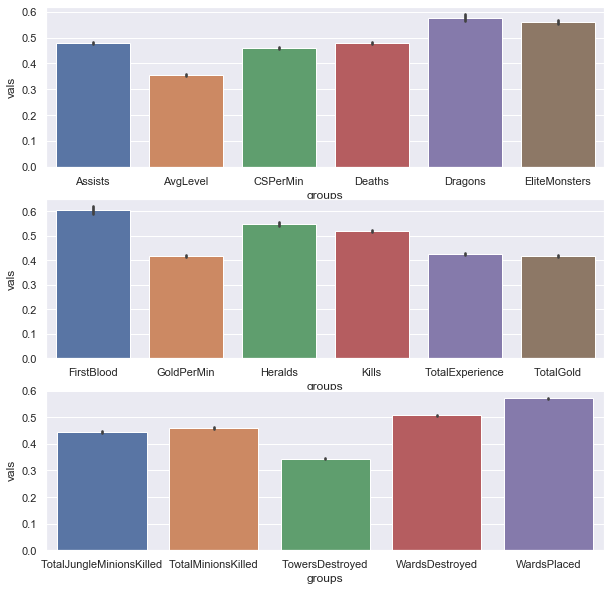

In [13]:

# fun (type, nrows, ncols, cols, width, data)
type = 1 # Type 1 - bar plot, 2 - violin plot, 3 - histogram
cols = 3 # cols = split of dataframe into managable chunks
nrows = 3 # number of plots in each row
width = 10 # width of plot. I set width to height for convinience
plotting_fn(type=1, nrows=nrows, cols=cols, 
            width=width, data = normalized_df_mod)

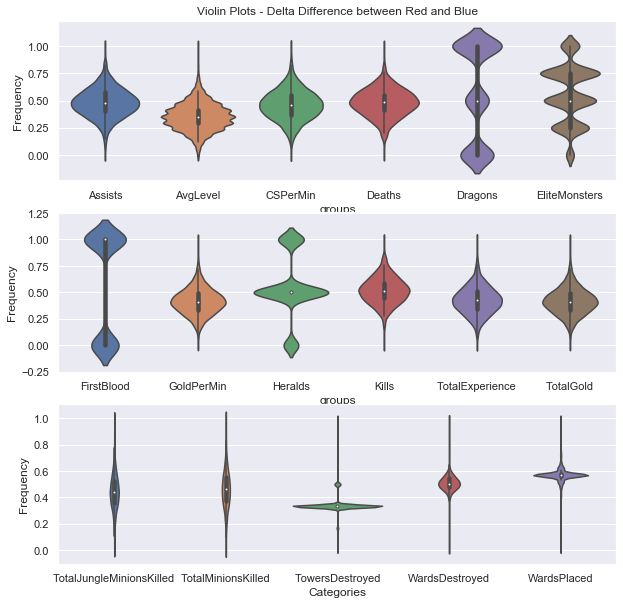

In [14]:
# Display the above in violin plot
plotting_fn(type=2, nrows=nrows, cols=cols, 
            width=width, data = normalized_df_mod)

A quick observation of the 2 plots above reveals that victory conditions are the least impacted by 'AvgLevel' and 'TowersDestroyed'. 

If you think about this logically, this would make sense as both teams should generally be balanced early on in the game and the number of towers destroyed would not vary if levels are similar. Therefore, it is less likely that these 2 elements would be predictive in determining if the blue team would win.

In [15]:
df_blue_train_test = raw_train_test_set.filter(regex='blue')
df_blue_train_test.columns.values

array(['blue_gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff',
       'blueExperienceDiff', 'blueCSPerMin', 'blueGoldPerMin'],
      dtype=object)

In [16]:
df_blue_drop = df_blue_train_test.drop(['blue_gameId', 'blueAvgLevel', 'blueTowersDestroyed'], axis = 1)
df_blue_drop.corr()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTotalGold,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin
blueWins,1.000000,0.001410,0.046703,0.201726,0.333801,-0.339568,0.273084,0.219322,0.209277,0.093586,0.414011,0.391830,0.226638,0.129523,0.508933,0.482979,0.226638,0.414011
blueWardsPlaced,0.001410,1.000000,0.040310,0.003616,0.012117,-0.000654,0.029504,0.022040,0.021474,0.008857,0.015351,0.026544,-0.034106,0.016972,0.010822,0.019433,-0.034106,0.015351
blueWardsDestroyed,0.046703,0.040310,1.000000,0.020091,0.033833,-0.075882,0.067633,0.040410,0.034270,0.022544,0.060608,0.071310,0.114447,-0.022810,0.079001,0.079263,0.114447,0.060608
blueFirstBlood,0.201726,0.003616,0.020091,1.000000,0.261083,-0.252861,0.224906,0.156990,0.141542,0.077194,0.305004,0.187995,0.127140,0.017366,0.374514,0.234216,0.127140,0.305004
blueKills,0.333801,0.012117,0.033833,0.261083,1.000000,0.004865,0.811828,0.182029,0.167437,0.085404,0.888853,0.469573,-0.031831,-0.108369,0.655791,0.583903,-0.031831,0.888853
blueDeaths,-0.339568,-0.000654,-0.075882,-0.252861,0.004865,1.000000,-0.027913,-0.206990,-0.194165,-0.092457,-0.158916,-0.460801,-0.466025,-0.231515,-0.637532,-0.576317,-0.466025,-0.158916
blueAssists,0.273084,0.029504,0.067633,0.224906,0.811828,-0.027913,1.000000,0.152113,0.167886,0.036803,0.747963,0.301537,-0.060963,-0.130015,0.550986,0.435311,-0.060963,0.747963
blueEliteMonsters,0.219322,0.022040,0.040410,0.156990,0.182029,-0.206990,0.152113,1.000000,0.782594,0.638791,0.240770,0.231852,0.121268,0.199983,0.283983,0.266410,0.121268,0.240770
blueDragons,0.209277,0.021474,0.034270,0.141542,0.167437,-0.194165,0.167886,0.782594,1.000000,0.020950,0.182547,0.178435,0.091479,0.166539,0.233883,0.210778,0.091479,0.182547
blueHeralds,0.093586,0.008857,0.022544,0.077194,0.085404,-0.092457,0.036803,0.638791,0.020950,1.000000,0.161067,0.151826,0.081698,0.115347,0.167021,0.167355,0.081698,0.161067


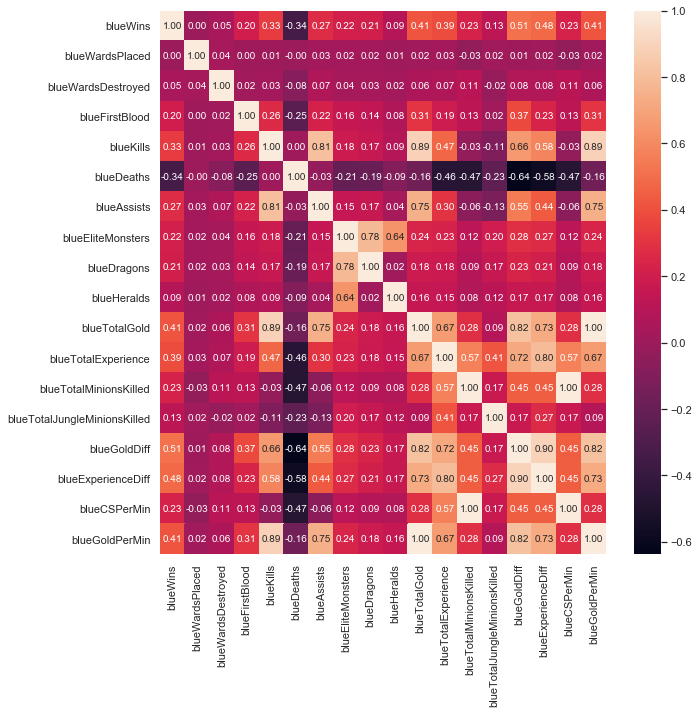

In [17]:
# Plot as Heat map to check for highly correlated variables
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_blue_drop.corr(), annot=True, fmt=".2f")

In observing the heat map above, highly correlated variables are defined as having correlation coeeficients of >0.7. Therefore, 
1. 'blueKills' is high correlatable to with 'blueAssists'. 
2. 'blueTotalGold' is perfectly correlated with 'blueGoldPerMin'. 
3. 'blueTotalMinionsKilled' is perfectly correlated with 'blueCSPerMin'. 
4. ''blueEliteMonsters' is highly correlated to 'blueDragons'. 

As these variables do not add any additional information when it comes to prediction of blue victory. , I will drop 1 of each pair and recreate the heatmap. 

Notes: Dropping these variables makes sense, because:
 - Kills and assists should be proportional.
 - Total gold generated is a summation from data related to number of kills, assists and minions killed.
 - The "farming" rate of minions killed should be proportional to CS per minute i.e. the more minions killed, the larger the cs per minute.
 - The "farming" rate of gold should be proportional to the total gold  i.e. the more minions killed, the larger the gold per minute and total gold.

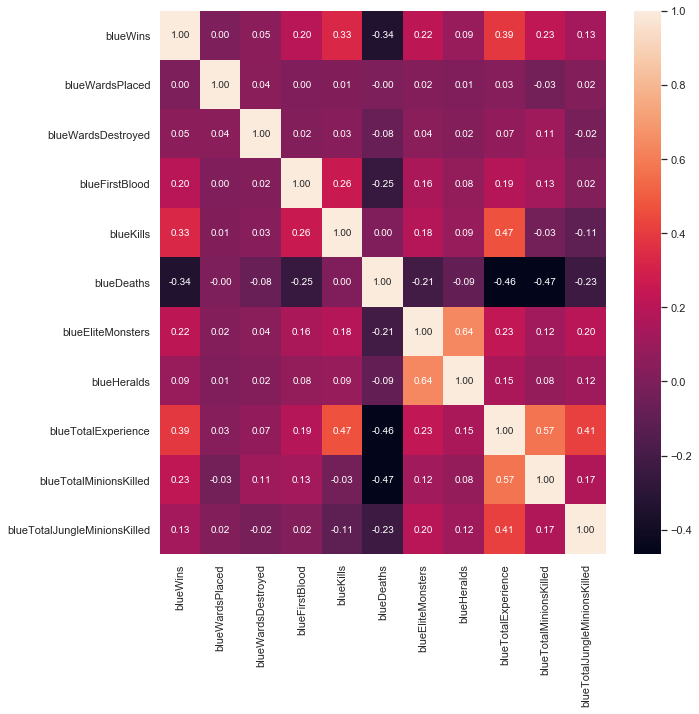

In [18]:
df_blue_drop = df_blue_drop.drop(['blueAssists', 'blueGoldPerMin', 'blueCSPerMin', 
                                  'blueDragons', 'blueGoldDiff', 'blueExperienceDiff',
                                  'blueTotalGold'
                            ], axis = 1)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_blue_drop.corr(), annot=True, fmt=".2f")

In [19]:
# Confirm properties of final dataframe
print(len(df_blue_drop))
print(df_blue_drop.info())
print(df_blue_drop.describe(include='all'))
print(df_blue_drop.columns.values)

7937
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7937 entries, 0 to 9877
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   blueWins                      7937 non-null   int64
 1   blueWardsPlaced               7937 non-null   int64
 2   blueWardsDestroyed            7937 non-null   int64
 3   blueFirstBlood                7937 non-null   int64
 4   blueKills                     7937 non-null   int64
 5   blueDeaths                    7937 non-null   int64
 6   blueEliteMonsters             7937 non-null   int64
 7   blueHeralds                   7937 non-null   int64
 8   blueTotalExperience           7937 non-null   int64
 9   blueTotalMinionsKilled        7937 non-null   int64
 10  blueTotalJungleMinionsKilled  7937 non-null   int64
dtypes: int64(11)
memory usage: 744.1 KB
None
          blueWins  blueWardsPlaced  blueWardsDestroyed  blueFirstBlood  \
count  7937.000000      79

#### Checkpoint File

In [20]:
cols = ['blueWardsPlaced', 
        'blueWardsDestroyed', 
        'blueFirstBlood',
        'blueKills', 
        'blueDeaths', 
        'blueEliteMonsters', 
        'blueHeralds',
        'blueTotalExperience', 
        'blueTotalMinionsKilled',
        'blueTotalJungleMinionsKilled',
        'blueWins'
       ]

data_preproc = df_blue_drop[cols]
base_filename = 'Blue_Wins_LoL'
csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
data_preproc.to_csv(csvs_sht, index = False, header=True)
print ("Final File Extract Produced")

Final File Extract Produced


# 2. Machine Learning

The following machine learning methods will be applied; accuracy scores will be compared to determine the best method. 

    2.1 Logistic Regression
    2.2 Decision Tree
    2.3 Support Vector Machine
    2.4 Random Forest
    2.5 Neural Net via Tensorflow

Next steps is to 
 - Feature Selection
 - Create a train-test set (80-20 split)
 - Normalize the data

In [21]:
# Feature Selection on data frame

#Create a copy
bl_train_test_set=df_blue_drop.copy()

Feature = bl_train_test_set[[
    'blueWardsPlaced', 
    'blueWardsDestroyed', 
    'blueFirstBlood',
    'blueKills', 
    'blueDeaths', 
    'blueEliteMonsters', 
    'blueHeralds',
    'blueTotalExperience', 
    'blueTotalMinionsKilled',
    'blueTotalJungleMinionsKilled',
]]
x=Feature

y = bl_train_test_set['blueWins'].values

print(x.head())
print(y[0:5])
print(x.shape, y.shape)

   blueWardsPlaced  blueWardsDestroyed  blueFirstBlood  blueKills  blueDeaths  \
0               28                   2               1          9           6   
1               12                   1               0          5           5   
2               15                   0               0          7          11   
3               43                   1               0          4           5   
4               75                   4               0          6           6   

   blueEliteMonsters  blueHeralds  blueTotalExperience  \
0                  0            0                17039   
1                  0            0                16265   
2                  1            0                16221   
3                  1            1                17954   
4                  0            0                18543   

   blueTotalMinionsKilled  blueTotalJungleMinionsKilled  
0                     195                            36  
1                     174                       

Now I split the dataframe into a training and testing set. I will do this with a 80-20 split.

In [22]:
from sklearn.model_selection import train_test_split

random_state = 42
test_size = 0.2

x_train, x_test, y_train, y_test  = train_test_split(
            x, y, test_size = test_size, random_state = random_state
)

print('Train Set: ', x_train.shape, y_train.shape)
print(x_train['blueTotalMinionsKilled'][0:5])
print('Test Set: ', x_test.shape, y_test.shape)
print(x_test['blueTotalMinionsKilled'][0:5])

Train Set:  (6349, 10) (6349,)
775     218
1805    204
6738    226
9760    220
3099    162
Name: blueTotalMinionsKilled, dtype: int64
Test Set:  (1588, 10) (1588,)
9804    202
6299    229
9674    248
7275    211
2116    238
Name: blueTotalMinionsKilled, dtype: int64


#### Normalize Data to give zero mean and unit variance.

This is only done to the features

In [23]:
from sklearn.preprocessing import StandardScaler

X_train = preprocessing.StandardScaler().fit(x_train).transform(x_train)
X_test = preprocessing.StandardScaler().fit(x_test).transform(x_test)
print('Normalized X Training Set: ', X_train[0:5])
print('Normalized X Testing Set: ', X_test[0:5])

Normalized X Training Set:  [[-0.40391882  0.08599071  0.99106215 -1.05871487 -0.39029981 -0.88570277
  -0.47480428 -0.88013997  0.06764728 -1.15972939]
 [-0.06975551 -0.82697755  0.99106215 -0.39679653  0.2973687  -0.88570277
  -0.47480428 -0.88680211 -0.57407059  0.15167318]
 [-0.06975551 -0.37049342  0.99106215 -0.39679653 -0.04646555  2.32579175
   2.10613097 -0.58117618  0.43434321 -0.95797515]
 [-0.51530658 -1.28346169 -1.00901846 -0.06583736 -0.04646555  0.72004449
  -0.47480428  0.53223489  0.15932127 -0.35271243]
 [-0.29253105 -1.28346169 -1.00901846  0.2651218   0.98503721 -0.88570277
  -0.47480428 -0.12981582 -2.49922422 -0.65534379]]
Normalized X Testing Set:  [[-0.4575663   0.05970218 -1.00252207  0.93645762  0.28167359  2.27897519
   2.02231145 -0.03664009 -0.6898733   0.54991501]
 [-0.28939427  0.98015909  0.99748427  0.26234398  0.28167359  0.70754115
  -0.49448368  1.43584893  0.52847284 -0.25800916]
 [ 2.40135823 -0.40052628 -1.00252207 -0.41176967 -0.04529838  0.7075

### 2.1 Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import log_loss

# c is the inverse of the regularization strength; regularization is to prevent overfitting 
C = 0.0001

LR = LogisticRegression(C = C, solver = 'liblinear')
LR.fit(X_train, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
yhat_LR = LR.predict(X_test)

# accuracy_score(y_true, y_pred)
mean_acc_LR = accuracy_score(y_test, yhat_LR)
conf_mat_LR = confusion_matrix(y_test, yhat_LR)

print('Logistic Regression')
print('==============================================\n')
print("True values:", y_test[0:5].round(1))
print("Pred values:", yhat_LR[0:5].round(1))
print('\n')
print('Mean Accuracy:', mean_acc_LR)
print('\n')
print('F1 Score:\n',classification_report(y_test, yhat_LR))

Logistic Regression

True values: [0 1 0 0 1]
Pred values: [1 1 1 0 1]


Mean Accuracy: 0.7027707808564232


F1 Score:
               precision    recall  f1-score   support

           0       0.70      0.70      0.70       789
           1       0.70      0.70      0.70       799

    accuracy                           0.70      1588
   macro avg       0.70      0.70      0.70      1588
weighted avg       0.70      0.70      0.70      1588



#### The accuracy score with a logistic regression is ~0.7.

A confusion matrix may be more valuable as it allows me to visualize the algorithm performance:

1. TN / True Negative: when a case was negative and predicted negative
2. TP / True Positive: when a case was positive and predicted positive
3. FN / False Negative: when a case was positive but predicted negative
4. FP / False Positive: when a case was negative but predicted positive
 - Precision = TP/(TP + FP)
 - Recall = TP/(TP + FN)
 - F1 Score = 2*(Recall * Precision) / (Recall + Precision)

In [26]:
def plot_conf_mat(cnf_matrix, classes, normalize, cmap, width, height):
    plt.figure(figsize=(width, height))
    if normalize == True:
        # np.newaxis - make it as column vector by inserting an axis 
        # along second dimension
        cnf_matrix = cnf_matrix.astype('float')/ cnf_matrix.sum(
            axis=1)[:,np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, non-normalized")
    
    #imshow() - creates image from 2D numpy array.
    plt.imshow(cnf_matrix, interpolation = 'nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks (tick_marks, classes, rotation=45)
    plt.yticks (tick_marks, classes)
    
    fmt = '.2f'if normalize else 'd'
    thres = cnf_matrix.max()/2
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt),
                 horizontalalignment='center',
                 fontsize=20,
                 color = 'yellow' if cnf_matrix[i, j] > thres else 'white'
                )
    # plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(None)
    return

Confusion Matrix, non-normalized


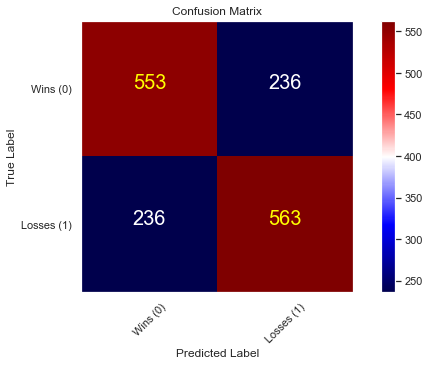

In [27]:
# Set normalize to true for the confusion matrix to print normalized values
normalize = False
cmap = plt.cm.seismic
width=10
height=width/2

plot_conf_mat(conf_mat_LR, 
              classes=['Wins (0)', 
                       'Losses (1)'],
              normalize=normalize, cmap=cmap, width=width, height=height)

### 2.2 Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# criterion="entropy" so that we can see information gain at each node
# Dont know what the best parameter is so use a grid search
max_depth = [{'max_depth': [x for x in range(1, 10)],
              'min_samples_split': [x*5 for x in range(1, 20)]             
             }]
tree = DecisionTreeClassifier(criterion="entropy")
win_tree = GridSearchCV(tree, max_depth, cv=10)

win_tree.fit(X_train, y_train)
win_tree.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=95,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Decision Tree

True values: [0 1 0 0 1]
Pred values: [1 1 0 0 1]


Mean Accuracy: 0.6926952141057935


F1 Score:
               precision    recall  f1-score   support

           0       0.67      0.74      0.71       789
           1       0.72      0.65      0.68       799

    accuracy                           0.69      1588
   macro avg       0.69      0.69      0.69      1588
weighted avg       0.69      0.69      0.69      1588

Confusion Matrix, non-normalized


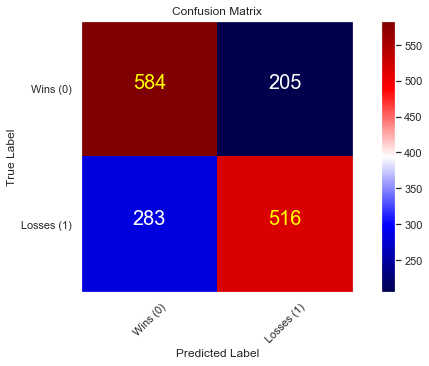

In [29]:
# Recreate the decision tree with the best atributes above
win_tree = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_split=95)
win_tree.fit(X_train, y_train)
yhat_tree = win_tree.predict(X_test)

# accuracy_score(y_true, y_pred)
mean_acc_tree = accuracy_score(y_test, yhat_tree)
conf_mat_tree = confusion_matrix(y_test, yhat_tree)

print('Decision Tree')
print('==============================================\n')
print("True values:", y_test[0:5].round(1))
print("Pred values:", yhat_tree[0:5].round(1))
print('\n')
print('Mean Accuracy:', mean_acc_tree)
print('\n')
print('F1 Score:\n',classification_report(y_test, yhat_tree))

plot_conf_mat(conf_mat_tree, 
              classes=['Wins (0)', 
                       'Losses (1)'],
              normalize=normalize, cmap=cmap, width=width, height=height)

C:\Users\quant\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


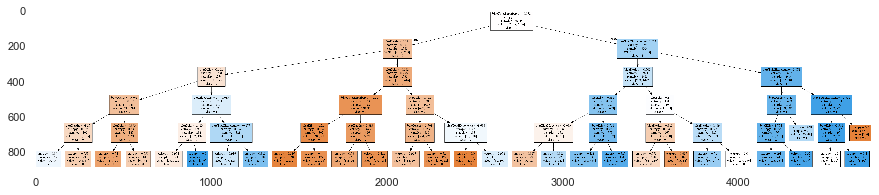

In [30]:
# Visualize Decision Tree
from sklearn import tree
import pydotplus
from sklearn.externals.six import StringIO
import matplotlib.image as mpimg

viz_data=pd.read_csv('Blue_Wins_LoL.csv')

dot_data = StringIO()
fname = 'decision_tree.png'
featurenm = viz_data.columns[0:10]
targetnm = viz_data['blueWins'].unique().tolist()

out = tree.export_graphviz(
    win_tree, 
    feature_names = featurenm, 
    out_file = dot_data, 
    class_names = np.unique(y_test).astype(str), 
    filled=True, 
    special_characters = True, 
    rotate = False
)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# To write to file
graph.write_png(fname)
img = mpimg.imread(fname)
plt.figure(figsize=(15, 10))
plt.imshow(img, interpolation='nearest')
plt.grid(None)

#### The accuracy score with a decision tree is ~0.69.

### 2.3 Random Forest

This is an ensemble method (based on the divide-and-conquer approach) of decision trees generated on a randomly split dataset. The four steps are:

1. Select random samples from a given dataset.
2. Construct a decision tree for each sample and get a prediction result from each decision tree.
3. Perform a vote for each predicted result.
4. Select the prediction result with the most votes as the final prediction.

Random Forest

True values: [0 1 0 0 1]
Pred values: [1 1 0 0 1]


Mean Accuracy: 0.6926952141057935


F1 Score:
               precision    recall  f1-score   support

           0       0.68      0.71      0.70       789
           1       0.70      0.67      0.69       799

    accuracy                           0.69      1588
   macro avg       0.69      0.69      0.69      1588
weighted avg       0.69      0.69      0.69      1588

Confusion Matrix, non-normalized


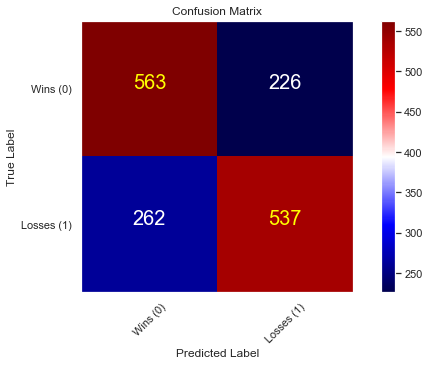

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Create a Gaussian Classifier
# Tried implemting a grid search but was too computationally expensive. 
# Will use the paramters from Decision Tree, but vary n_estimators
win_rf=RandomForestClassifier(n_estimators=200, criterion="entropy", max_depth=5, min_samples_split=95)
win_rf.fit(X_train, y_train)
yhat_rf = win_rf.predict(X_test)

# accuracy_score(y_true, y_pred)
mean_acc_rf = accuracy_score(y_test, yhat_rf)
conf_mat_rf = confusion_matrix(y_test, yhat_rf)

print('Random Forest')
print('==============================================\n')
print("True values:", y_test[0:5].round(1))
print("Pred values:", yhat_rf[0:5].round(1))
print('\n')
print('Mean Accuracy:', mean_acc_rf)
print('\n')
print('F1 Score:\n',classification_report(y_test, yhat_rf))

plot_conf_mat(conf_mat_rf, 
              classes=['Wins (0)', 
                       'Losses (1)'],
              normalize=normalize, cmap=cmap, width=width, height=height)

#### The accuracy score with a Random Forest approach is ~0.70.

### 2.4 Support Vector Machine (SVM)

The kernel function is an unknown; i will use a radial basis function (RBF) as the default

Support Vector Machine

True values: [0 1 0 0 1]
Pred values: [1 1 1 0 1]


Mean Accuracy: 0.7040302267002518


F1 Score:
               precision    recall  f1-score   support

           0       0.69      0.73      0.71       789
           1       0.72      0.68      0.70       799

    accuracy                           0.70      1588
   macro avg       0.70      0.70      0.70      1588
weighted avg       0.70      0.70      0.70      1588

Confusion Matrix, non-normalized


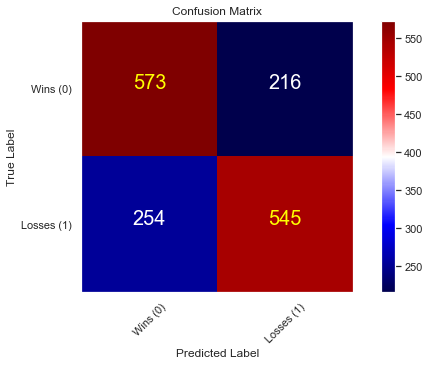

In [32]:
from sklearn import svm
model_svm = svm.SVC(kernel = 'rbf')
model_svm.fit(X_train, y_train)

yhat_svm = model_svm.predict(X_test)

# accuracy_score(y_true, y_pred)
mean_acc_svm = accuracy_score(y_test, yhat_svm)
conf_mat_svm = confusion_matrix(y_test, yhat_svm)

print('Support Vector Machine')
print('==============================================\n')
print("True values:", y_test[0:5].round(1))
print("Pred values:", yhat_svm[0:5].round(1))
print('\n')
print('Mean Accuracy:', mean_acc_svm)
print('\n')
print('F1 Score:\n',classification_report(y_test, yhat_svm))

plot_conf_mat(conf_mat_svm, 
              classes=['Wins (0)', 
                       'Losses (1)'],
              normalize=normalize, cmap=cmap, width=width, height=height)

#### The accuracy score with a SVM approach is ~0.70.

### 2.5 Neural Net (NN) with Tensorflow

In [33]:
import tensorflow as tf

### Model
In this section, I will cover the following:
1. Outline of the model
2. Optimizers & loss funtion
3. Early stopping and training

In [34]:
# Intialize hyperparameters learning rate, epochs and batch size
epochs = 10 # Too large a value will overfit.
batch_size = 200 # mini-batch gradient descent. 

# Input size is dependent on number of inputs, output size on number of 
# outputs and hidden layer size is kept constant for every dense layer
input_size = 10
output_size = 2 
hidden_layer_size = 100 # Width of the hidden layer.

I will start with a model that is 3 layers 'depth'. The 'Hidden layer' is defined as a combination of linear + non-linear function, and is created using tf.keras.layers.Dense. 

This is basically implementing: output = activation(dot(input, weight) + bias). 

The function takes several arguments, but the most critical ones are the hidden_layer_size and the activation function

In [35]:
# Outline of the model
model_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid'), # 1st hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid'), # 2nd hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid'), # 3rd hidden layer
    # the final layer is activated with softmax
    tf.keras.layers.Dense(output_size, activation='softmax'), # output layer
])

# Using the optimizer which is the "Adaptive Momentum Estimate (adam)"
# and determining the Loss function as the 'sparse_categorical_crossentropy'
# produce the metric 'accuracy' per iteration.
model_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

##### Training

In [36]:
# Moniter validation loss and set an early stopping mechanism 
# once there is an increase. At patience=2, will be tolerant 
# against random validation loss increases and will allow x
# consecutive increases
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

model_nn.fit(X_train, y_train,
         batch_size = batch_size,
         epochs=epochs,
         callbacks=[early_stopping],
         validation_data = (X_test, y_test),
         validation_steps = 1,
         verbose = 2
         )

yhat_nn = model_nn.predict_classes(X_test)

# accuracy_score(y_true, y_pred)
test_loss, test_accuracy = model_nn.evaluate(X_test, y_test)

print('Neural Network')
print('==============================================\n')
print("True values:", y_test[0:5].round(1))
print("Pred values:", yhat_nn[0:5].round(1))
print('\n')
print('Accuracy:', test_accuracy)
print('\n')
print('Loss:\n', test_loss)

Train on 6349 samples, validate on 1588 samples
Epoch 1/10
6349/6349 - 0s - loss: 0.7350 - accuracy: 0.5054 - val_loss: 0.0871 - val_accuracy: 0.4450
Epoch 2/10
6349/6349 - 0s - loss: 0.6748 - accuracy: 0.6007 - val_loss: 0.0821 - val_accuracy: 0.6550
Epoch 3/10
6349/6349 - 0s - loss: 0.6417 - accuracy: 0.6725 - val_loss: 0.0782 - val_accuracy: 0.7300
Epoch 4/10
6349/6349 - 0s - loss: 0.5920 - accuracy: 0.6930 - val_loss: 0.0710 - val_accuracy: 0.7300
Epoch 5/10
6349/6349 - 0s - loss: 0.5645 - accuracy: 0.7034 - val_loss: 0.0696 - val_accuracy: 0.7450
Epoch 6/10
6349/6349 - 0s - loss: 0.5560 - accuracy: 0.7103 - val_loss: 0.0711 - val_accuracy: 0.7150
Epoch 7/10
6349/6349 - 0s - loss: 0.5553 - accuracy: 0.7157 - val_loss: 0.0686 - val_accuracy: 0.7350
Epoch 8/10
6349/6349 - 0s - loss: 0.5505 - accuracy: 0.7192 - val_loss: 0.0693 - val_accuracy: 0.7050
Epoch 9/10
6349/6349 - 0s - loss: 0.5486 - accuracy: 0.7204 - val_loss: 0.0697 - val_accuracy: 0.7000
Epoch 10/10
6349/6349 - 0s - loss:

#### The accuracy score with a NN approach is ~0.7

### Score Summaries

| No  | Model                  | Accuracy Score        |
|-----|------------------------|-----------------------|
| 2.1 | Logistic               | 0.702                 |
| 2.2 | Decision Tree          | 0.693                 |
| 2.3 | Random Forest          | 0.697                 |
| 2.4 | Support Vector Machine | 0.704                 |
| 2.5 | Neural Network         | 0.703                 |

All the methods seem to have similar accuracies.

#### At this stage, building and training the models is done. There should be no further tweaks to the input parameters.

Pickling the data & models to save offsite.

In [37]:
# Pickle all sets and models

# Validation Set
with open('validate_set', 'wb') as file:
    pickle.dump(raw_validate_set, file)

# Normalized Train and Test Set
with open('X_train', 'wb') as file:
    pickle.dump(X_train, file)
with open('X_test', 'wb') as file:
    pickle.dump(X_test, file)
with open('y_train', 'wb') as file:
    pickle.dump(y_train, file)
with open('y_test', 'wb') as file:
    pickle.dump(y_test, file)

# Models
with open('Log_Reg', 'wb') as file:
    pickle.dump(LR, file)
with open('Decision_Tree', 'wb') as file:
    pickle.dump(win_tree, file)
with open('Random_Forest', 'wb') as file:
    pickle.dump(win_rf, file)
with open('SVM', 'wb') as file:
    pickle.dump(model_svm, file)
with open('SVM', 'wb') as file:
    pickle.dump(model_svm, file)

#Tensorflow model

csvs_sht = os.path.join(dir_name)
tf.saved_model.save(model_nn, csvs_sht)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:/Users/quant/Anaconda3/@Projects/LoL_Diamond_Ranked_Games\assets


# 3. Validation on the "out-of-sample" test set

In [38]:
# Recall the data set
print('Validation Set: ', raw_validate_set[0:5])
print('Shape Validation Set: ', raw_validate_set.shape)

Validation Set:      blue_gameId  blueWins  blueWardsPlaced  blueWardsDestroyed  \
7    4496759358         0               16                   2   
8    4443048030         0               16                   3   
13   4524924257         0               14                   3   
17   4503636905         0               43                   3   
19   4457103291         0               11                   3   

    blueFirstBlood  blueKills  blueDeaths  blueAssists  blueEliteMonsters  \
7                0          5          13            3                  0   
8                0          7           7            8                  0   
13               0          4           9            1                  1   
17               0          3           7            3                  1   
19               0          5           9            5                  0   

    blueDragons  ...  redTotalGold  redAvgLevel  redTotalExperience  \
7             0  ...         17920          6.6     

In [39]:
cols = ['blueWardsPlaced', 
        'blueWardsDestroyed', 
        'blueFirstBlood',
        'blueKills', 
        'blueDeaths', 
        'blueEliteMonsters', 
        'blueHeralds',
        'blueTotalExperience', 
        'blueTotalMinionsKilled',
        'blueTotalJungleMinionsKilled',
        'blueWins'
       ]

blue_validation_set = raw_validate_set[cols]
Feature = blue_validation_set[[
    'blueWardsPlaced', 
    'blueWardsDestroyed', 
    'blueFirstBlood',
    'blueKills', 
    'blueDeaths', 
    'blueEliteMonsters', 
    'blueHeralds',
    'blueTotalExperience', 
    'blueTotalMinionsKilled',
    'blueTotalJungleMinionsKilled',
]]
x_val=Feature

y_val = blue_validation_set['blueWins'].values

print(x_val.head())
print(y_val[0:5])
print(x_val.shape, y_val.shape)

    blueWardsPlaced  blueWardsDestroyed  blueFirstBlood  blueKills  \
7                16                   2               0          5   
8                16                   3               0          7   
13               14                   3               0          4   
17               43                   3               0          3   
19               11                   3               0          5   

    blueDeaths  blueEliteMonsters  blueHeralds  blueTotalExperience  \
7           13                  0            0                16138   
8            7                  0            0                18527   
13           9                  1            1                17213   
17           7                  1            1                16888   
19           9                  0            0                17924   

    blueTotalMinionsKilled  blueTotalJungleMinionsKilled  
7                      209                            48  
8                      189        

In [40]:
# Normalize to give 0 mean and unit variance
X_val=preprocessing.StandardScaler().fit(x_val).transform(x_val)
print('Normalized Test Set: ', X_val[0:5])

Normalized Test Set:  [[-0.35439064 -0.39134657 -1.0176637  -0.36673834  2.35416643 -0.87109971
  -0.49081011 -1.47213687 -0.35853512 -0.25557879]
 [-0.35439064  0.07953016 -1.0176637   0.29763279  0.29356342 -0.87109971
  -0.49081011  0.52829068 -1.27886451  1.06499879]
 [-0.46329588  0.07953016 -1.0176637  -0.6989239   0.98043109  0.72783757
   2.03744782 -0.57198634 -0.31251865  0.15075278]
 [ 1.11583002  0.07953016 -1.0176637  -1.03110947  0.29356342  0.72783757
   2.03744782 -0.84412487 -0.63463394  0.35391856]
 [-0.62665373  0.07953016 -1.0176637  -0.36673834  0.98043109 -0.87109971
  -0.49081011  0.02336903 -1.32488098 -0.25557879]]


In [41]:
yhat_val = model_nn.predict_classes(X_val)

# accuracy_score(y_true, y_pred)
val_loss, val_accuracy = model_nn.evaluate(X_val, y_val)

print('Neural Network')
print('==============================================\n')
print("True values:", y_val[0:5].round(1))
print("Pred values:", yhat_val[0:5].round(1))
print('\n')
print('Accuracy:', test_accuracy)
print('\n')
print('Loss:\n', test_loss)

1942/1942 [==============================] - 0s 21us/sample - loss: 0.5411 - accuracy: 0.7230
Neural Network

True values: [0 0 0 0 0]
Pred values: [0 0 0 0 0]


Accuracy: 0.7008816


Loss:
 0.5610580481870349


Therefore, this works shows that with a neural net model, I can predict with **70% accuracy** wheter the blue team will win, as long as the following inputs are present:
- 'blueWardsPlaced', 
- 'blueWardsDestroyed', 
- 'blueFirstBlood',
- 'blueKills', 
- 'blueDeaths', 
- 'blueEliteMonsters', 
- 'blueHeralds',
- 'blueTotalExperience', 
- 'blueTotalMinionsKilled',
- 'blueTotalJungleMinionsKilled',

In [42]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 29.783066272735596 seconds
